## Testing out iminuit fitting for FOM, will replace curve fit

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import probfit

import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

import iminuit
from iminuit import Minuit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### load and prepare data

In [2]:
#folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/', '75_9e-3/PORT_2b/isaura/']
folder_paths = ['15_15_15/PORT_1a/isaura/', '15_15_15/PORT_1b/isaura/', '15_15_15/PORT_2a/isaura/', '15_15_15/PORT_2b/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = low_e_tracks['event'].value_counts(sort = False)

# apply this to numb_of_tracks
low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)



Porting 15_15_15/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 15_15_15/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 15_15_15/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Porting 15_15_15/PORT_2b/isaura/
50
100
150
200
250
300
Tracks: 80864
Done! Tracks available: 259847


/tmp/ipykernel_15566/625699918.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 39.84 %
Absolute Cut efficiency:
Efficiency: 39.84 %
One track cut
Relative Cut efficiency:
Efficiency: 64.26 %
Absolute Cut efficiency:
Efficiency: 52.09 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 89.49 %
Absolute Cut efficiency:
Efficiency: 84.06 %
Energy cut
Relative Cut efficiency:
Efficiency: 8.62 %
Absolute Cut efficiency:
Efficiency: 7.88 %


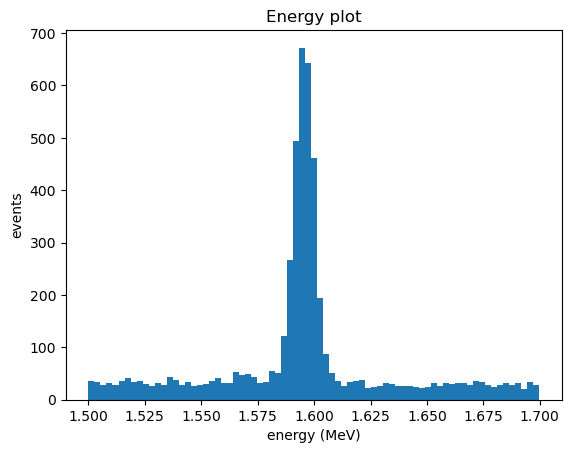

In [3]:
func.plot_hist(cut_tracks[0], binning = 75, log = False)

In [4]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 15_15_15/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 15_15_15/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 15_15_15/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976
Loading positrons from 15_15_15/PORT_2b/isaura/
Positron events: 12817
Port finished! Tracks available: 47202


In [5]:
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

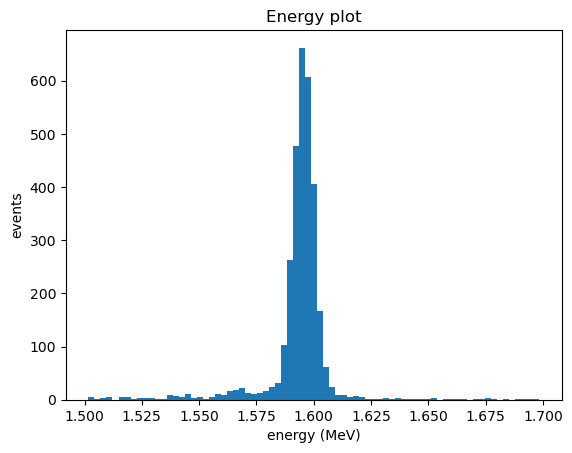

In [6]:
func.plot_hist(ecut_positron_df, binning = 75, log = False)

In [7]:
cut_list = np.linspace(0,0.6, 61)

# Fit
#fom_out_fit = func.fom_calc_MC(cut_tracks[0], pos_events, cut_list, binning = 60)

In [8]:
def fit(c, C1, C2, mu, sigma):
    m = Minuit(c, ns = 400, a = 1, nb = 20, tau = 0.1, C1 = C1, C2 = C2, mu = mu, sigma = sigma)
    m.fixed['mu'] = True
    m.fixed['sigma'] = True
    m.fixed['C1'] = True
    m.fixed['C2'] = True
    m.limits["ns", "nb"] = (0, None)
    m.migrad()
    assert m.valid
    return m

In [9]:
# create a distribution function for the bins
def integral(xe, ns, a, mu, sigma, C1, C2, nb, tau):

    return ns * skewnorm_func.cdf(x, a, mu, sigma) + C1 

### unbinned extended maximum likelihood fit for C1 C2 

In [10]:
# set range we're considering
fit_range = (1.5, 1.7)
binning = 80

In [11]:
def bck_func_no_N(x, tau):
    return np.exp(-x/tau)

def gauss_no_N(x, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return np.exp(-numer/denom)

In [12]:
# Normalise and extend
sig_norm = probfit.Normalized(func.sig_func_no_N, fit_range)
sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

bck_norm = probfit.Normalized(bck_func_no_N, fit_range)
bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

gauss_norm = probfit.Normalized(gauss_no_N, fit_range)
gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

### collecting C1 and C2 parameters

In [13]:

e_s = ecut_positron_df['energy'].to_numpy()
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)



In [14]:
# minimise that mfer
m.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   0 - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   1 - FCN =  -31245.53859823 Edm =      4101.86 NCalls =     93
VariableMetric: Iteration #   2 - FCN =  -32701.34672537 Edm =      154.269 NCalls =    115
VariableMetric: Iteration #   3 - FCN =  -32748.75879748 Edm =      97.5243 NCalls =    129
VariableMetric: Iteration #   4 - FCN =  -32785.39340618 Edm =      6.77937 NCalls =    143
VariableMetric: Iteration #   5 - FCN =  -32789.28646603 Edm =      8.52043 NCalls =    157
VariableMetric: Iteration #   6 - FCN =  -32793.78683505 Edm =      1.10539 NCalls =    171
VariableMetric: Iteration #   7 - FCN =  -32801.06577986 Edm =       2.8386 NCalls =    187
VariableMetric: Iteration #   8 - FCN =  -32810.06312682 Edm =       3.7456 NCalls =    205
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -3.282e+04                 │        Nfcn = 410 (410 total)        │
│ EDM = 2.28e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

 22 - FCN =  -32817.88581241 Edm =  2.28001e-05 NCalls =    410


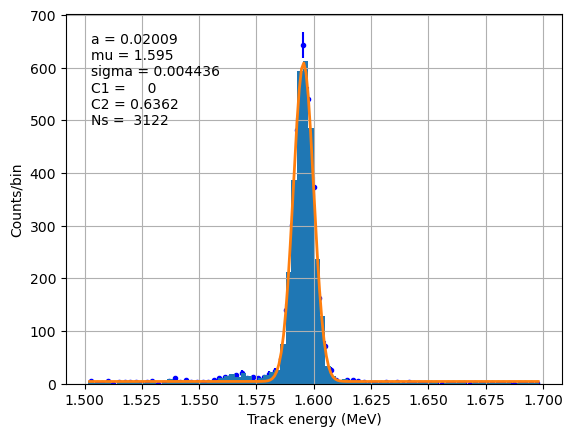

"\nC1_test = 1\nx_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE\ny_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)\nplt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))\nplt.ylim([0,600])\nplt.legend()\nplt.show()\n"

In [15]:
# plot output
heights, bins, _ = plt.hist(e_s, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)


'''
C1_test = 1
x_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE
y_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)
plt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))
plt.ylim([0,600])
plt.legend()
plt.show()
'''

In [16]:
# collect C1 and C2
print(m.params)
C2 = m.params[4][2]
C1 = m.params[3][2]
# collect the gaussian here as well
mu = m.params[1][2]
sigma = m.params[2][2]

┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [17]:
'''
# do signal and background fit over all the data now
e_tracks = cut_tracks[0]['energy'].to_numpy()

# create signal background pdf
pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

lh_sb = probfit.UnbinnedLH(pdf_sb, e_tracks, extended = True)


y, x = np.histogram(e_tracks, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals_sb = [len(e_s), len(e_tracks) - len(e_s), 0, mu, sigma, 100, C1, C2]
nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']



m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

"\n# do signal and background fit over all the data now\ne_tracks = cut_tracks[0]['energy'].to_numpy()\n\n# create signal background pdf\npdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)\n\nlh_sb = probfit.UnbinnedLH(pdf_sb, e_tracks, extended = True)\n\n\ny, x = np.histogram(e_tracks, fit_bins)\nx = shift_to_bin_centers(x)\n\n\n\n# give it rough starting spots\nvals_sb = [len(e_s), len(e_tracks) - len(e_s), 0, mu, sigma, 100, C1, C2]\nnm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']\n\n\n\nm_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,\n         fix_C2=True, fix_sigma=True, print_level = 2)\n#m.limits['mu'] = (1.4, 1.7)\n#m.limits['C1'] = (0, None)\n#m.limits['C2'] = (0, None)\n#m.limits['sigma'] = (0, None)\n"

In [18]:
'''
# minimise that mfer
m_sb.migrad()
'''

'\n# minimise that mfer\nm_sb.migrad()\n'

In [19]:
'''
# plot output
heights, bins, _ = plt.hist(e_tracks, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_sb.show(bins=binning+1, parts=True)
plt.show()
'''

'\n# plot output\nheights, bins, _ = plt.hist(e_tracks, binning)\nplt.xlabel("Track energy (MeV)")\nplt.ylabel("Counts/bin")\nlh_sb.show(bins=binning+1, parts=True)\nplt.show()\n'

In [20]:
'''
display(m_sb.params)
print(m_sb.params[0][1], m_sb.params[0][2])
print(len(m.params)+1)
'''

'\ndisplay(m_sb.params)\nprint(m_sb.params[0][1], m_sb.params[0][2])\nprint(len(m.params)+1)\n'

In [21]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = value
    #dict[key].append(value)

# pull out the relevant values
#fit_params = {}
#[add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

In [22]:
# collect the fom stuff
#ns0 = quad(func.sig_func, fit_range[0], fit_range[1], args = (fit_params['Ns'],fit_params['a'], mu, sigma, C1, C2))#/bin_width
#nb0 = quad(func.bck_func, fit_range[0], fit_range[1], args = (fit_params['Nb'], fit_params['tau']))#/bin_width

#####print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(cut_tracks[0].index)))

In [23]:
'''
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []

ns0 = fit_params['Ns']
nb0 = fit_params['Nb']
ns_l.append(fit_params['Ns'])
nb_l.append(fit_params['Nb'])
'''

"\n# create list for fom values\ne       = []\nb       = []\nns_l      = []\nnb_l      = []\nfom     = []\nfom_err = []\ne_err = []\nb_err = []\n\nns0 = fit_params['Ns']\nnb0 = fit_params['Nb']\nns_l.append(fit_params['Ns'])\nnb_l.append(fit_params['Nb'])\n"

In [24]:
'''
print(ns_l)
print(nb_l)
'''

'\nprint(ns_l)\nprint(nb_l)\n'

### now to create the loop, and collect the gaussian and the full fit on repeat (this takes ages)

In [25]:
#del lh_g
#del m_g 
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []


def gaussian_fit(data, plot = False):
    '''
    Fit gaussian to the data
    '''
    blob_np = data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1))
    
    # minimise it
    m_g.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_data, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']


    return (mu, sigma)


def sb_fit(data, mu, sigma, C1, C2, plot = False):
    '''
    Fit signal and background to data
    '''
    blob_np = data['energy'].to_numpy()
    # create signal background pdf
    pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [len(blob_np)/2, len(blob_np)/2, 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, limit_tau=(0.1,None))

    # minimise that mfer
    m_sb.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    return (fit_params['Ns'], fit_params['Nb'])



Blob cut: 0.0 MeV
Mu fit completed, with values:
mu: 1.595520279733812
sigma: 0.004607638815220153


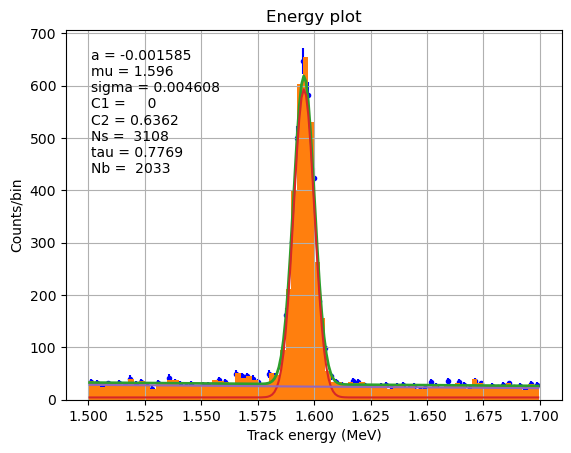

Signal events: 3107.910030378629
Background events: 2025.0628631147881
Total Events by addition: 5132.972893493417
Total Events by row counting: 5131


Blob cut: 0.01 MeV
Mu fit completed, with values:
mu: 1.595520279733812
sigma: 0.004607638815220153


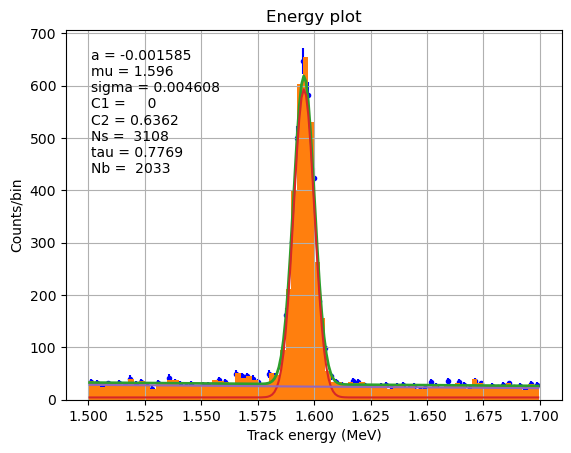

Signal events: 3107.910030378629
Background events: 2025.0628631147881
Total Events by addition: 5132.972893493417
Total Events by row counting: 5131


Blob cut: 0.02 MeV
Mu fit completed, with values:
mu: 1.5955000507473234
sigma: 0.004620016524121229


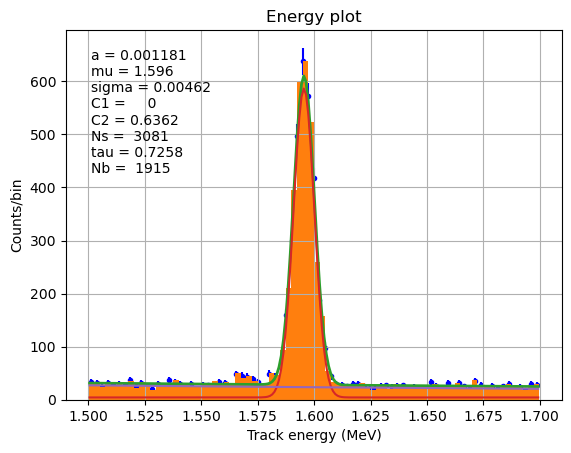

Signal events: 3080.5929451024463
Background events: 1907.2754012886253
Total Events by addition: 4987.868346391071
Total Events by row counting: 4986


Blob cut: 0.03 MeV
Mu fit completed, with values:
mu: 1.5955043641631064
sigma: 0.004623496552304124


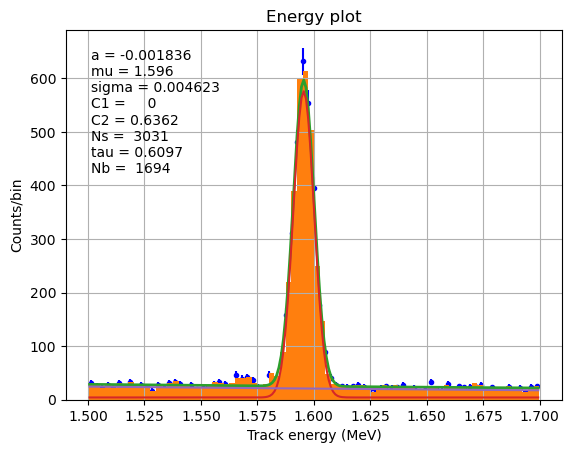

Signal events: 3030.557760929416
Background events: 1686.6301119237633
Total Events by addition: 4717.187872853179
Total Events by row counting: 4713


Blob cut: 0.04 MeV
Mu fit completed, with values:
mu: 1.5954801055990782
sigma: 0.004603117414975625


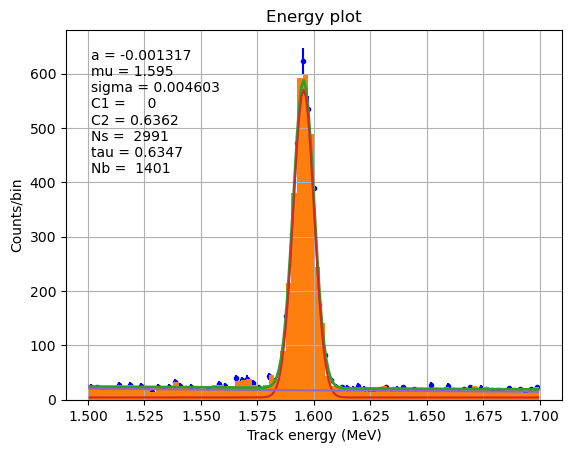

Signal events: 2990.863541961489
Background events: 1394.6992448837052
Total Events by addition: 4385.562786845194
Total Events by row counting: 4382


Blob cut: 0.05 MeV
Mu fit completed, with values:
mu: 1.5954928019235803
sigma: 0.004557260617784145


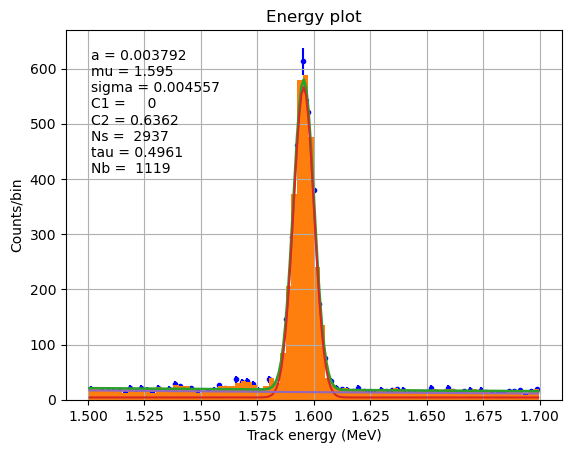

Signal events: 2936.5342361316357
Background events: 1113.4043639175643
Total Events by addition: 4049.9386000492
Total Events by row counting: 4047


Blob cut: 0.06 MeV
Mu fit completed, with values:
mu: 1.5954988922640356
sigma: 0.004501757477751267


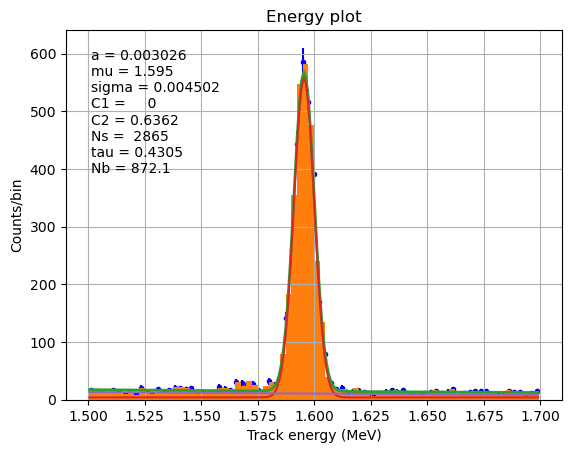

Signal events: 2864.9099037579563
Background events: 867.1770172366848
Total Events by addition: 3732.0869209946413
Total Events by row counting: 3728


Blob cut: 0.07 MeV
Mu fit completed, with values:
mu: 1.595550691876558
sigma: 0.004419163210605387


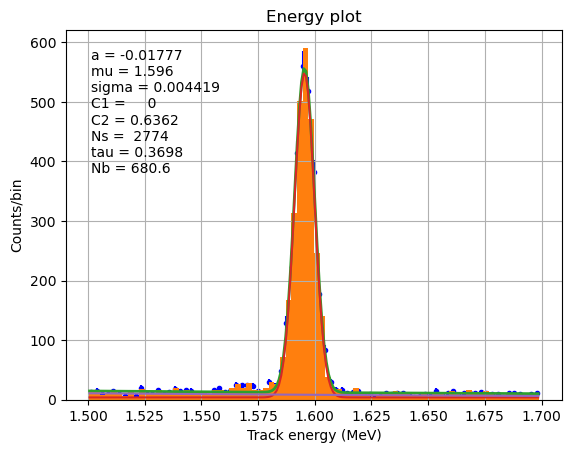

Signal events: 2773.6990626649604
Background events: 676.3360057971307
Total Events by addition: 3450.035068462091
Total Events by row counting: 3445


Blob cut: 0.08 MeV
Mu fit completed, with values:
mu: 1.5955831489575047
sigma: 0.0043965010468668365


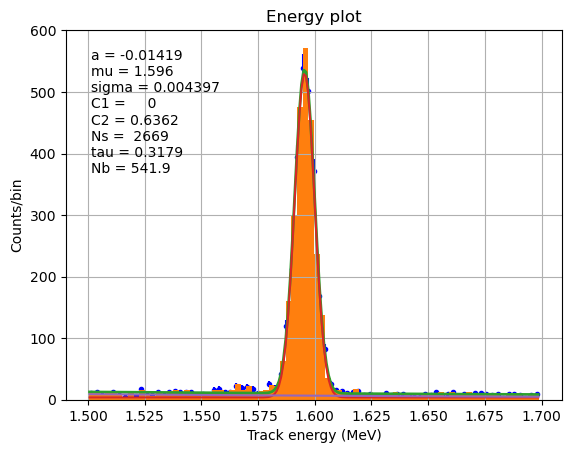

Signal events: 2668.5687390185744
Background events: 538.0699985765348
Total Events by addition: 3206.638737595109
Total Events by row counting: 3202


Blob cut: 0.09 MeV
Mu fit completed, with values:
mu: 1.5955629293108615
sigma: 0.004319495746755826


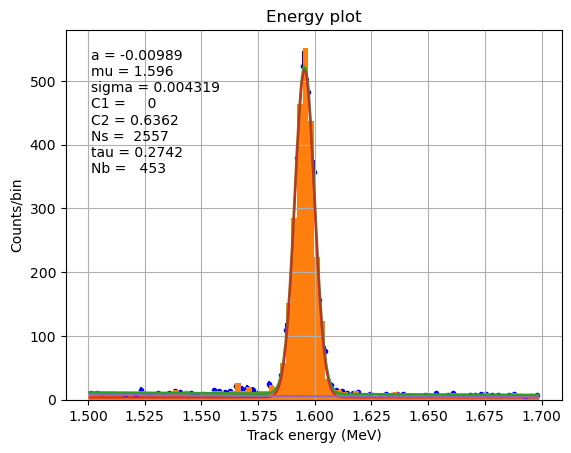

Signal events: 2557.4686243412043
Background events: 449.55451660015075
Total Events by addition: 3007.023140941355
Total Events by row counting: 3003


Blob cut: 0.1 MeV
Mu fit completed, with values:
mu: 1.595603700465874
sigma: 0.004311816982805466


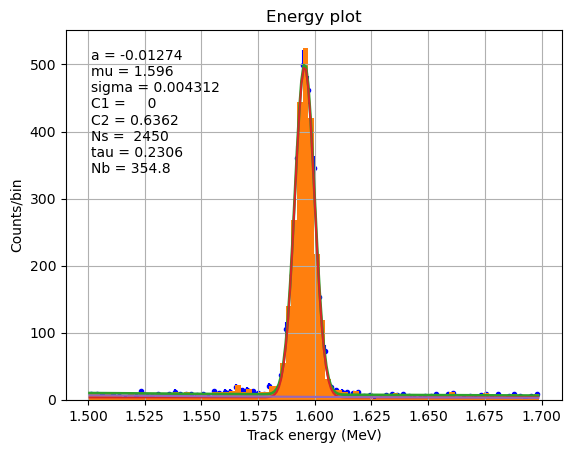

Signal events: 2449.6388535343376
Background events: 351.75038366926645
Total Events by addition: 2801.389237203604
Total Events by row counting: 2798


Blob cut: 0.11 MeV
Mu fit completed, with values:
mu: 1.595577377534004
sigma: 0.004327894095730249


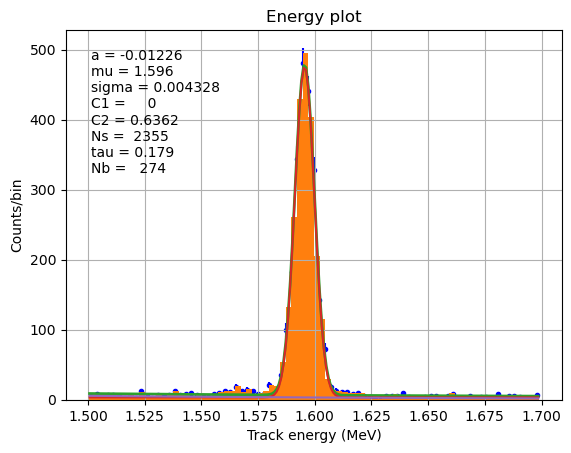

Signal events: 2355.4805770096814
Background events: 271.2322039840843
Total Events by addition: 2626.7127809937656
Total Events by row counting: 2624


Blob cut: 0.12 MeV
Mu fit completed, with values:
mu: 1.5955621915903415
sigma: 0.004337796327685871


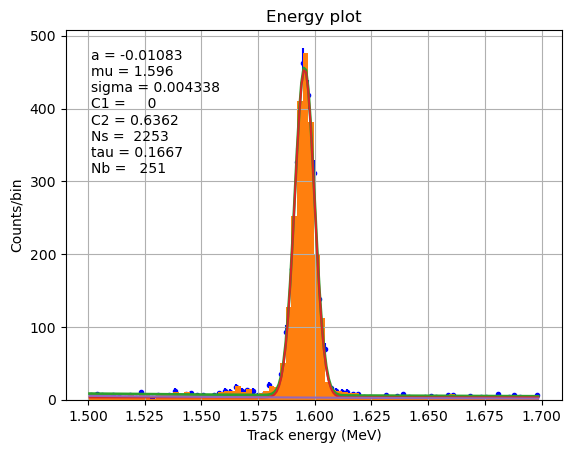

Signal events: 2253.3321721083903
Background events: 248.381075364681
Total Events by addition: 2501.7132474730715
Total Events by row counting: 2499


Blob cut: 0.13 MeV
Mu fit completed, with values:
mu: 1.5955486105212882
sigma: 0.004372111776284757


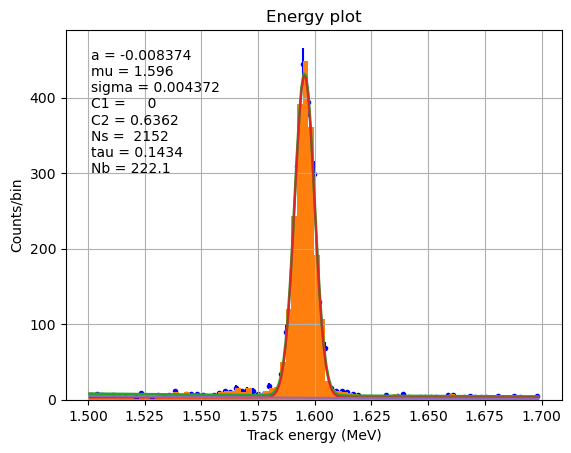

Signal events: 2151.6401683318595
Background events: 219.7445179863954
Total Events by addition: 2371.384686318255
Total Events by row counting: 2369


Blob cut: 0.14 MeV
Mu fit completed, with values:
mu: 1.5955342021538539
sigma: 0.004333058280904367


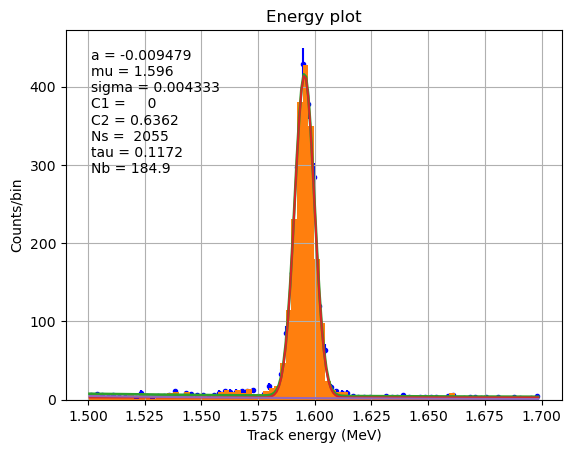

Signal events: 2055.3918993262523
Background events: 182.7586406983673
Total Events by addition: 2238.1505400246197
Total Events by row counting: 2236


Blob cut: 0.15 MeV
Mu fit completed, with values:
mu: 1.595524098956184
sigma: 0.004321935733200042


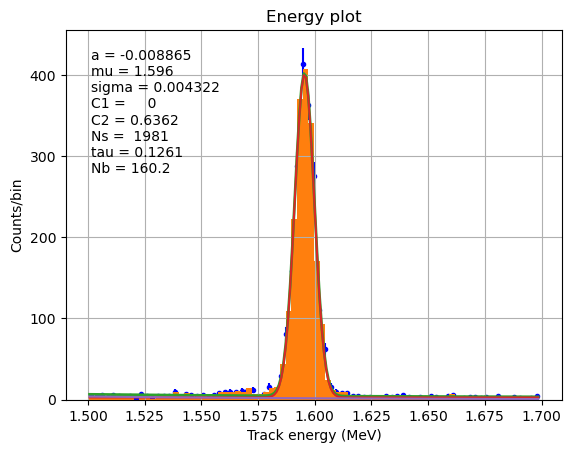

Signal events: 1981.0096036626708
Background events: 158.18820308646605
Total Events by addition: 2139.197806749137
Total Events by row counting: 2137


Blob cut: 0.16 MeV
Mu fit completed, with values:
mu: 1.5955175020061532
sigma: 0.004312473710371376


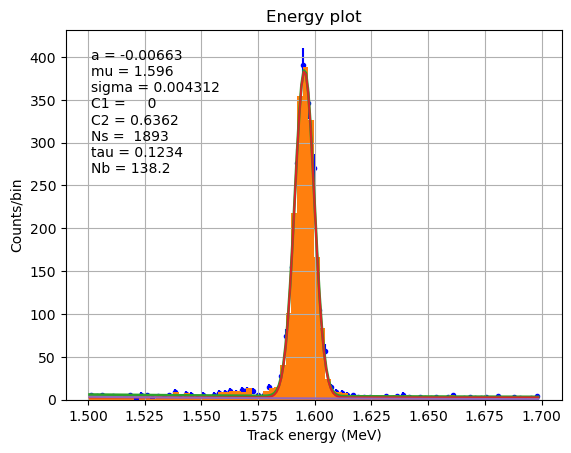

Signal events: 1892.7795897193346
Background events: 136.28491769631805
Total Events by addition: 2029.0645074156525
Total Events by row counting: 2027


Blob cut: 0.17 MeV
Mu fit completed, with values:
mu: 1.595537231044822
sigma: 0.004293571300818383


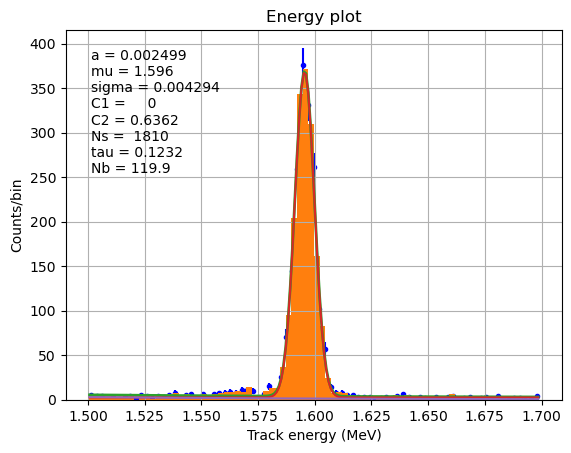

Signal events: 1809.577794675919
Background events: 118.17562301314705
Total Events by addition: 1927.753417689066
Total Events by row counting: 1926


Blob cut: 0.18 MeV
Mu fit completed, with values:
mu: 1.5955738662014
sigma: 0.004291436680760563


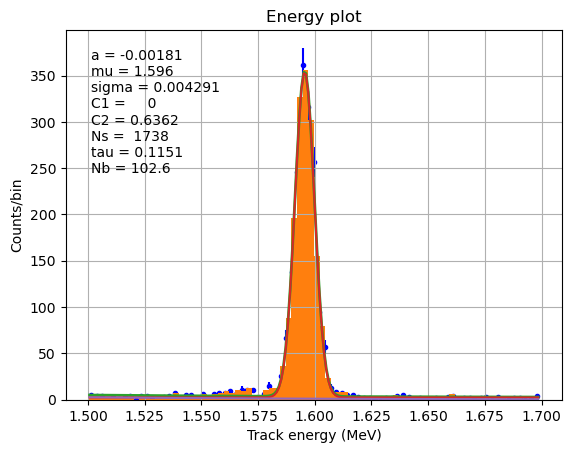

Signal events: 1737.7044568311915
Background events: 100.9510331995748
Total Events by addition: 1838.6554900307663
Total Events by row counting: 1837


Blob cut: 0.19 MeV
Mu fit completed, with values:
mu: 1.5955506147942078
sigma: 0.004279961054683755


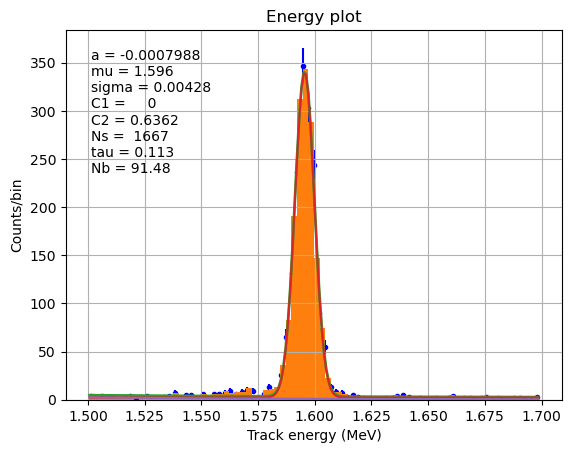

Signal events: 1666.679491585997
Background events: 89.94921636804045
Total Events by addition: 1756.6287079540375
Total Events by row counting: 1755


Blob cut: 0.2 MeV
Mu fit completed, with values:
mu: 1.59556675481857
sigma: 0.004299375452724549


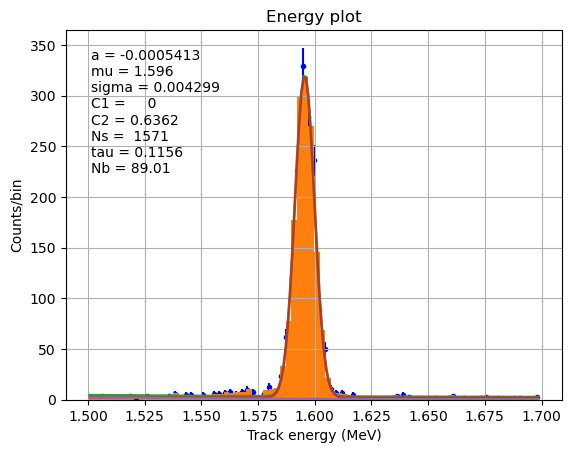

Signal events: 1570.9386662851925
Background events: 87.56682424328795
Total Events by addition: 1658.5054905284805
Total Events by row counting: 1657


Blob cut: 0.21 MeV
Mu fit completed, with values:
mu: 1.5956052337212883
sigma: 0.004231212263622488


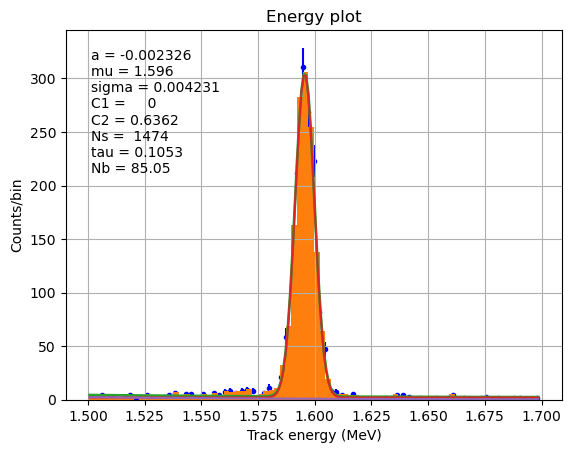

Signal events: 1473.6067340382563
Background events: 83.70709031222216
Total Events by addition: 1557.3138243504784
Total Events by row counting: 1556


Blob cut: 0.22 MeV
Mu fit completed, with values:
mu: 1.5956786140173411
sigma: 0.004259810585216668


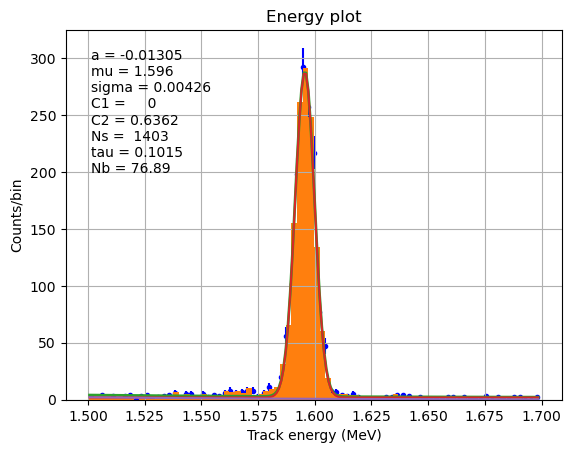

Signal events: 1403.4429690132254
Background events: 75.63702759602225
Total Events by addition: 1479.0799966092477
Total Events by row counting: 1478


Blob cut: 0.23 MeV
Mu fit completed, with values:
mu: 1.5956577561558736
sigma: 0.004356042328998224


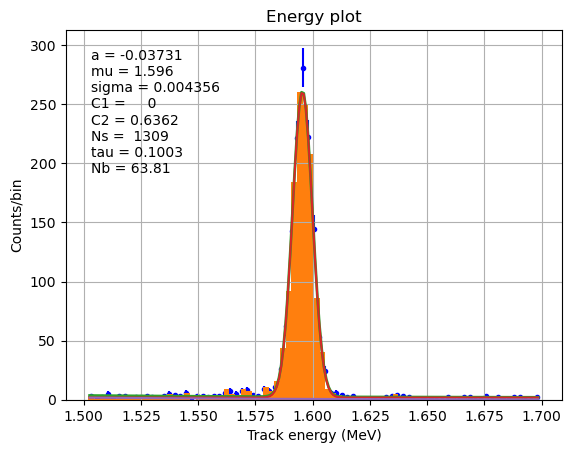

Signal events: 1309.1811212082755
Background events: 62.6607026626506
Total Events by addition: 1371.8418238709262
Total Events by row counting: 1368


Blob cut: 0.24 MeV
Mu fit completed, with values:
mu: 1.595608841838896
sigma: 0.00438047245978361


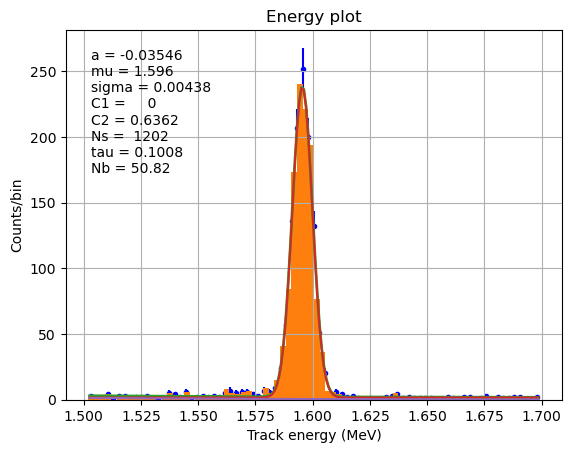

Signal events: 1202.471271473051
Background events: 49.79596285549638
Total Events by addition: 1252.2672343285474
Total Events by row counting: 1249


Blob cut: 0.25 MeV
Mu fit completed, with values:
mu: 1.5955103432482591
sigma: 0.004356876887357945


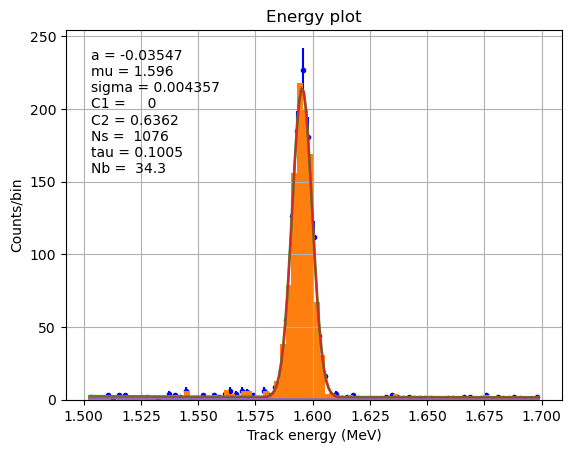

Signal events: 1076.2152337103294
Background events: 33.43588174811933
Total Events by addition: 1109.6511154584487
Total Events by row counting: 1107


Blob cut: 0.26 MeV
Mu fit completed, with values:
mu: 1.5955713219313516
sigma: 0.004313100628189598


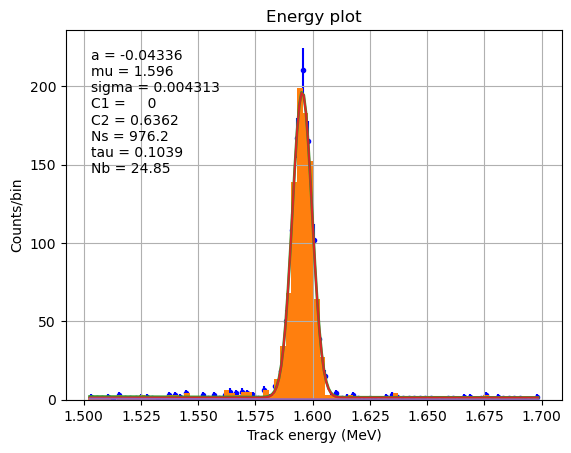

Signal events: 976.1509144418135
Background events: 24.09063105396747
Total Events by addition: 1000.241545495781
Total Events by row counting: 998


Blob cut: 0.27 MeV
Mu fit completed, with values:
mu: 1.5954903301631358
sigma: 0.004348176945321145


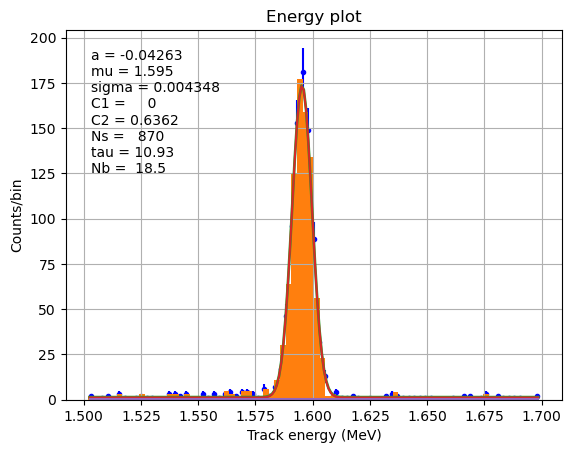

Signal events: 869.9634367877152
Background events: 17.773844687814712
Total Events by addition: 887.7372814755299
Total Events by row counting: 886


Blob cut: 0.28 MeV
Mu fit completed, with values:
mu: 1.5955641698039136
sigma: 0.004321560839182235


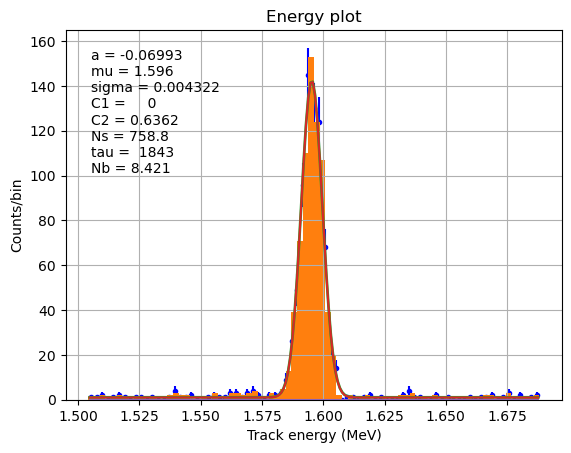

Signal events: 758.8223810003956
Background events: 9.05572628363102
Total Events by addition: 767.8781072840266
Total Events by row counting: 760


Blob cut: 0.29 MeV
Mu fit completed, with values:
mu: 1.5956951281837428
sigma: 0.00418494498990963


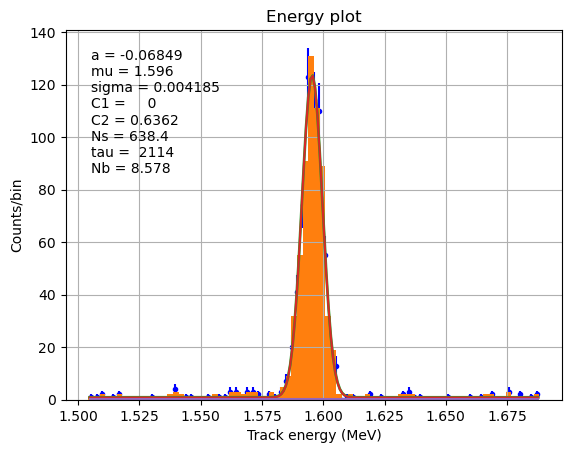

Signal events: 638.3903005400458
Background events: 9.108667350060209
Total Events by addition: 647.498967890106
Total Events by row counting: 641


Blob cut: 0.3 MeV
Mu fit completed, with values:
mu: 1.5956037375250212
sigma: 0.004187189541021069


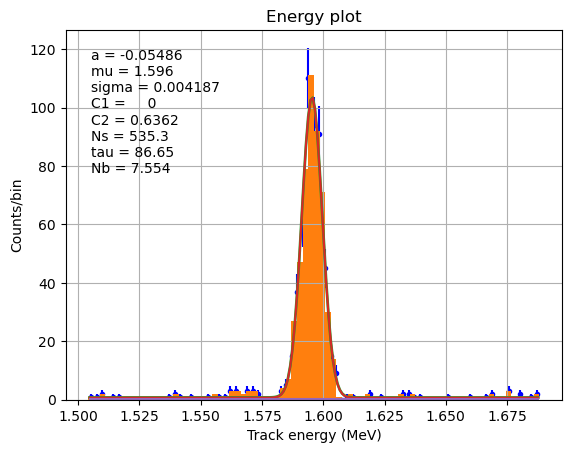

Signal events: 535.3217245745427
Background events: 7.996652004670303
Total Events by addition: 543.318376579213
Total Events by row counting: 538


Blob cut: 0.31 MeV
Mu fit completed, with values:
mu: 1.5956410235166336
sigma: 0.004278005119598333


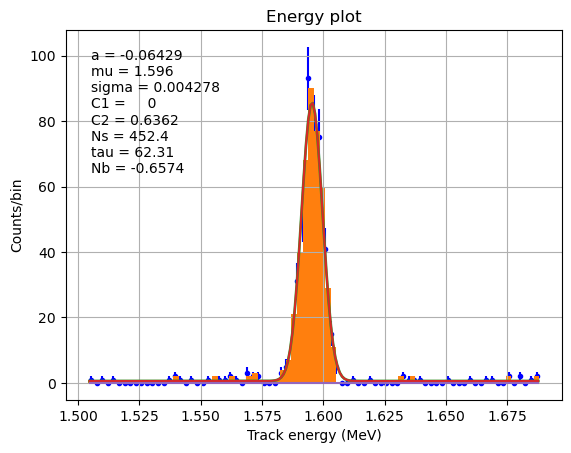

Signal events: 452.3592307804516
Background events: -0.3132600901034186
Total Events by addition: 452.04597069034816
Total Events by row counting: 448


Blob cut: 0.32 MeV
Mu fit completed, with values:
mu: 1.595819268067193
sigma: 0.004444006286113551


/tmp/ipykernel_15566/4113164158.py:34: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_15566/4113164158.py:42: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))


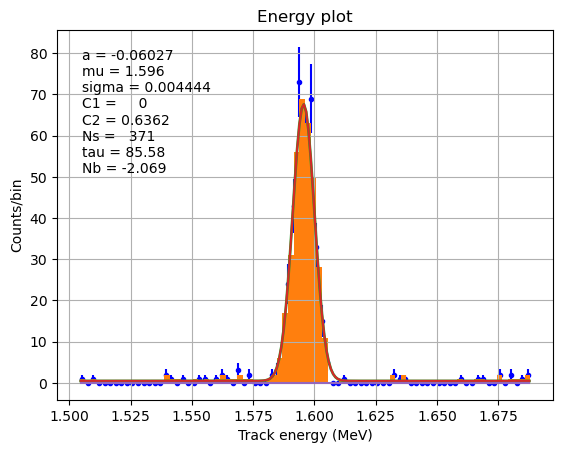

Signal events: 370.99401296333696
Background events: -1.7960163332040076
Total Events by addition: 369.19799663013293
Total Events by row counting: 366


Blob cut: 0.33 MeV
Mu fit completed, with values:
mu: 1.5959858989990423
sigma: 0.004346685710088821


/tmp/ipykernel_15566/4113164158.py:34: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_15566/4113164158.py:42: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))


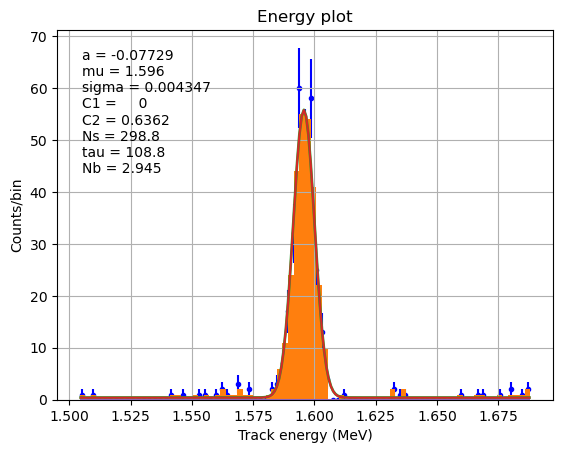

Signal events: 298.7824721166574
Background events: 3.18006144430572
Total Events by addition: 301.9625335609631
Total Events by row counting: 299


Blob cut: 0.34 MeV
Mu fit completed, with values:
mu: 1.5958409826382065
sigma: 0.0040714147503776305


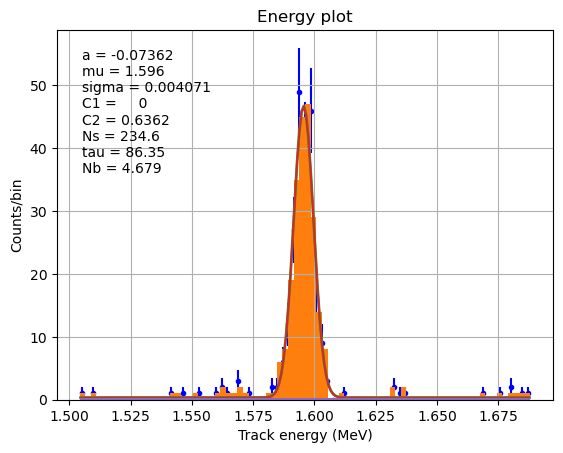

Signal events: 234.61791800904018
Background events: 4.868277154875706
Total Events by addition: 239.48619516391588
Total Events by row counting: 237


Blob cut: 0.35000000000000003 MeV
Mu fit completed, with values:
mu: 1.595606128210602
sigma: 0.004042261621477381


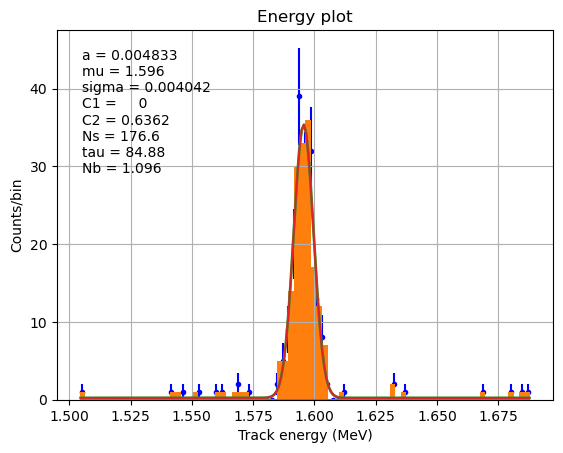

Signal events: 176.61368552970293
Background events: 1.2275582578030138
Total Events by addition: 177.84124378750596
Total Events by row counting: 176


Blob cut: 0.36 MeV
Mu fit completed, with values:
mu: 1.5957979600489682
sigma: 0.004072384954810358


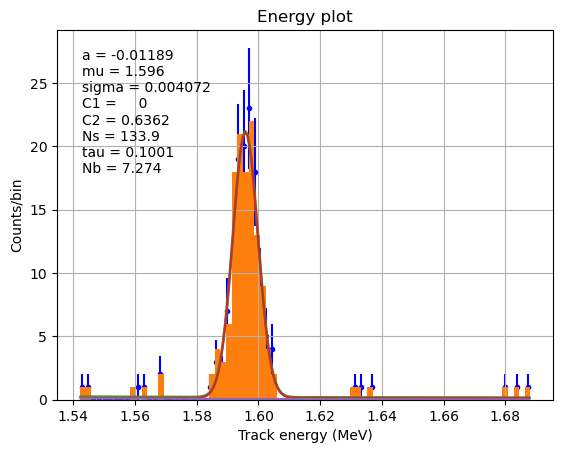

Signal events: 133.91201869688186
Background events: 7.124098843905748
Total Events by addition: 141.03611754078761
Total Events by row counting: 134


Blob cut: 0.37 MeV
Mu fit completed, with values:
mu: 1.5955022399274035
sigma: 0.004172053934754251


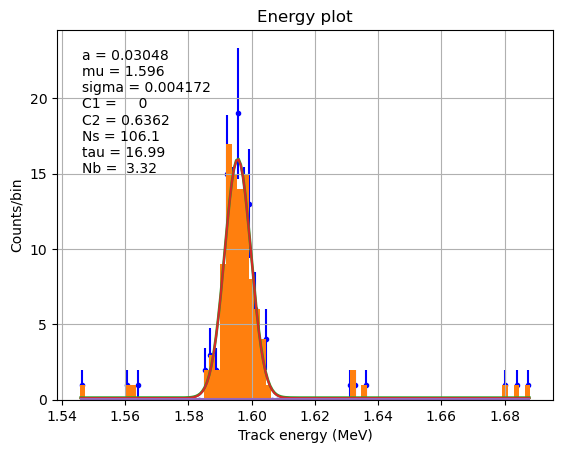

Signal events: 106.14316536189084
Background events: 3.2239217588831406
Total Events by addition: 109.36708712077397
Total Events by row counting: 105


Blob cut: 0.38 MeV
Mu fit completed, with values:
mu: 1.5948665624736353
sigma: 0.00405871679444526


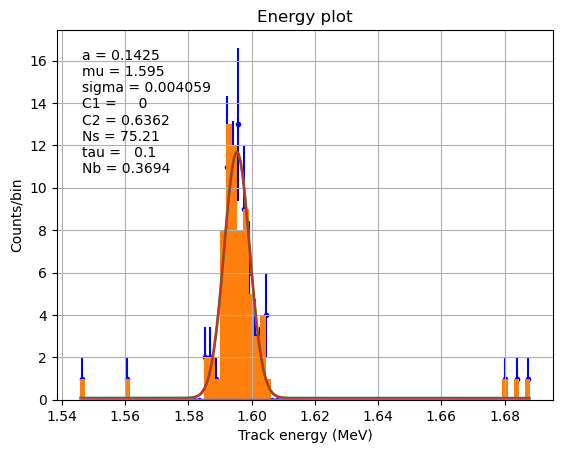

Signal events: 75.2145061474552
Background events: 0.39649506613932606
Total Events by addition: 75.61100121359452
Total Events by row counting: 73


Blob cut: 0.39 MeV
Mu fit completed, with values:
mu: 1.594875025175431
sigma: 0.00403503396307806


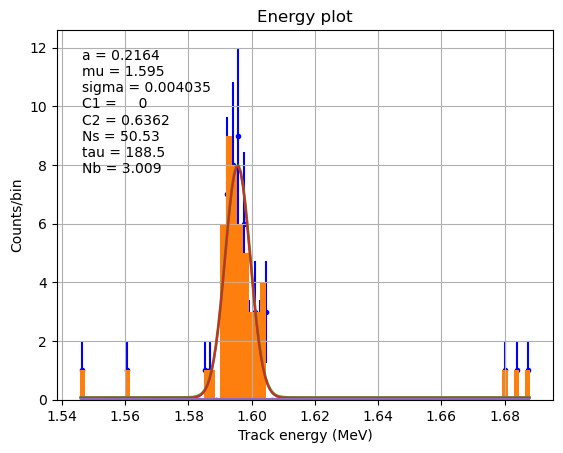

Signal events: 50.53159298834825
Background events: 2.9608123122101726
Total Events by addition: 53.492405300558424
Total Events by row counting: 51


Blob cut: 0.4 MeV
Mu fit completed, with values:
mu: 1.5945152581958084
sigma: 0.0037794088532757497


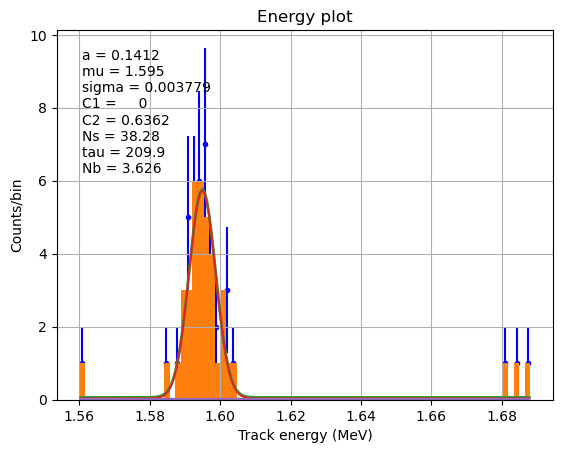

Signal events: 38.2823264018132
Background events: 3.584337929242948
Total Events by addition: 41.86666433105615
Total Events by row counting: 39


Blob cut: 0.41000000000000003 MeV
Mu fit completed, with values:
mu: 1.5952726250057163
sigma: 0.0033167556002788334


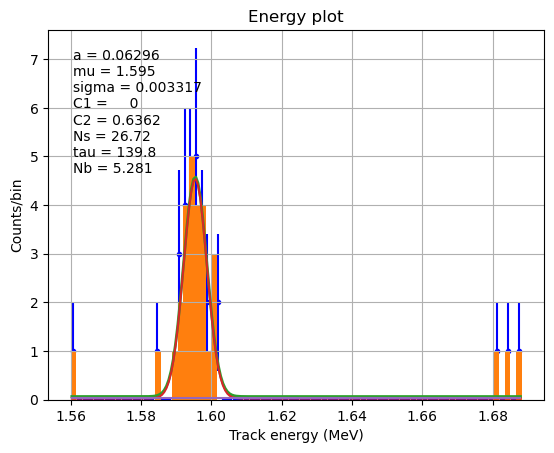

Signal events: 26.72286302042198
Background events: 5.245949974193527
Total Events by addition: 31.968812994615504
Total Events by row counting: 29


Blob cut: 0.42 MeV
Mu fit completed, with values:
mu: 1.5941575065702833
sigma: 0.0011005953305471068


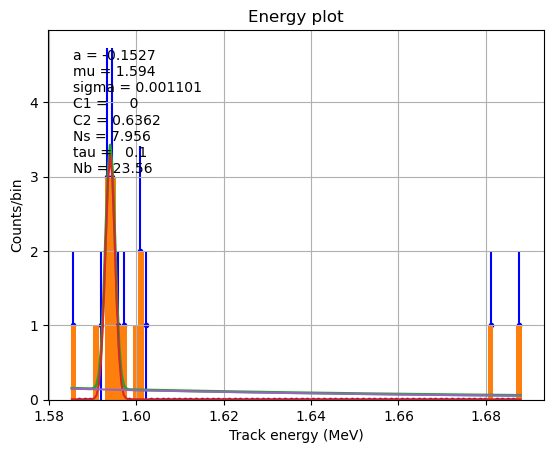

Signal events: 7.955675310453846
Background events: 23.504853677849745
Total Events by addition: 31.46052898830359
Total Events by row counting: 15


Blob cut: 0.43 MeV
Mu fit completed, with values:
mu: 1.5956495109467568
sigma: 0.0061275800239764715


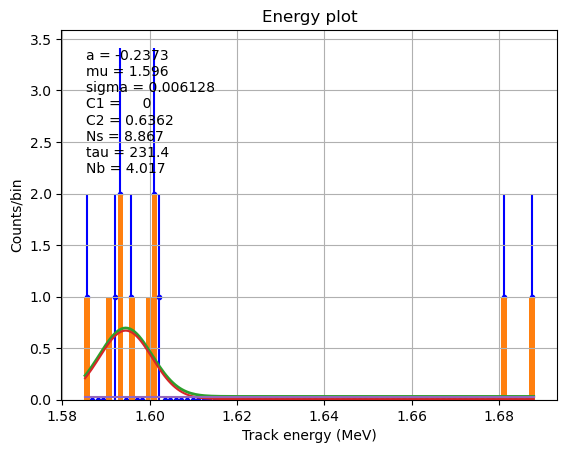

Signal events: 8.86696670689153
Background events: 4.001079150072132
Total Events by addition: 12.868045856963661
Total Events by row counting: 10


Blob cut: 0.44 MeV
Mu fit completed, with values:
mu: 1.5965079716891748
sigma: 0.006320737957062333


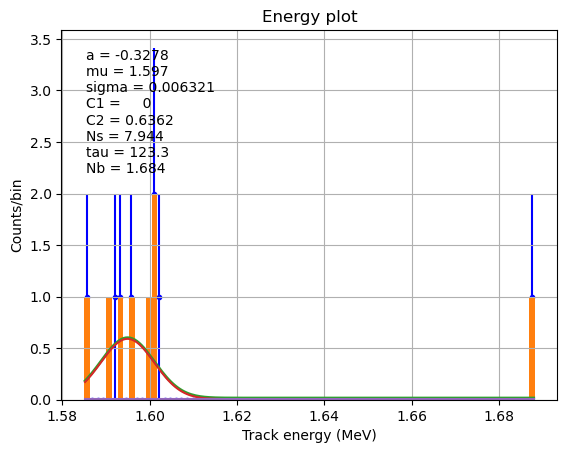

Signal events: 7.943865512702618
Background events: 1.6733037139973141
Total Events by addition: 9.617169226699932
Total Events by row counting: 8


Blob cut: 0.45 MeV
Mu fit completed, with values:
mu: 1.601394438417144
sigma: 0.00032181605971186425


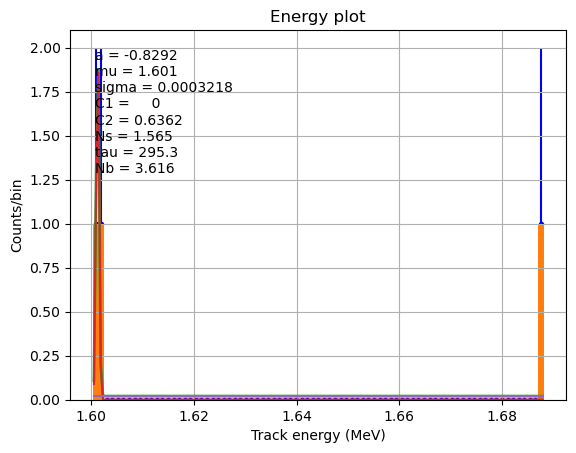

Signal events: 1.5649155347083743
Background events: 3.623898675939313
Total Events by addition: 5.1888142106476876
Total Events by row counting: 3


Blob cut: 0.46 MeV
Mu fit completed, with values:
mu: 1.601394438417144
sigma: 0.00032181605971186425


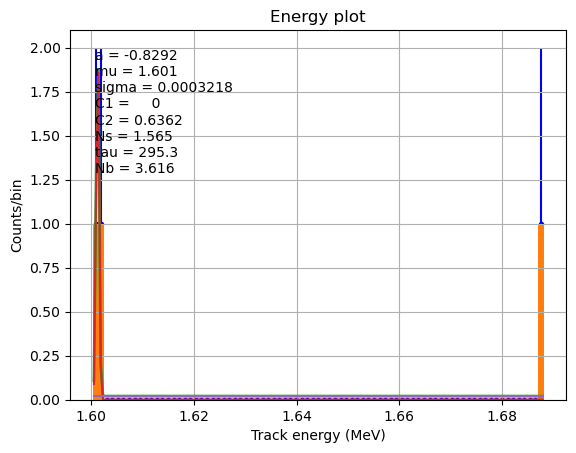

Signal events: 1.5649155347083743
Background events: 3.623898675939313
Total Events by addition: 5.1888142106476876
Total Events by row counting: 3


Blob cut: 0.47000000000000003 MeV
Mu fit completed, with values:
mu: 1.601394438417144
sigma: 0.00032181605971186425


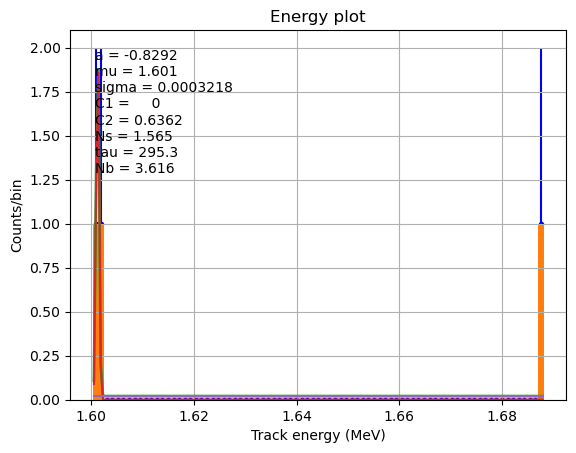

Signal events: 1.5649155347083743
Background events: 3.623898675939313
Total Events by addition: 5.1888142106476876
Total Events by row counting: 3


Blob cut: 0.48 MeV
Mu fit completed, with values:
mu: 1.59973957058798
sigma: 0.0005652811652156086


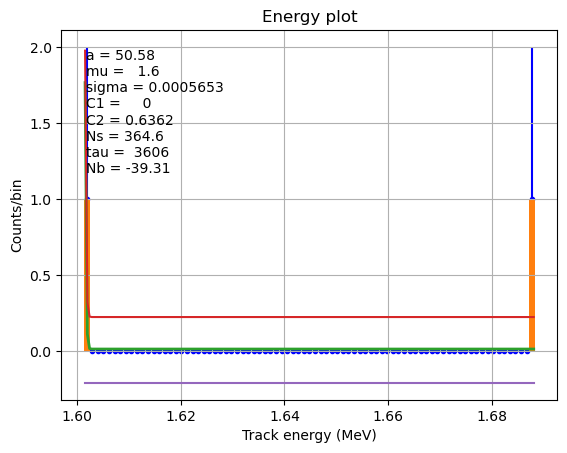

Signal events: 364.5611252270611
Background events: -39.31385664982642
Total Events by addition: 325.24726857723465
Total Events by row counting: 2


Blob cut: 0.49 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


/tmp/ipykernel_15566/4113164158.py:34: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_15566/4113164158.py:42: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))


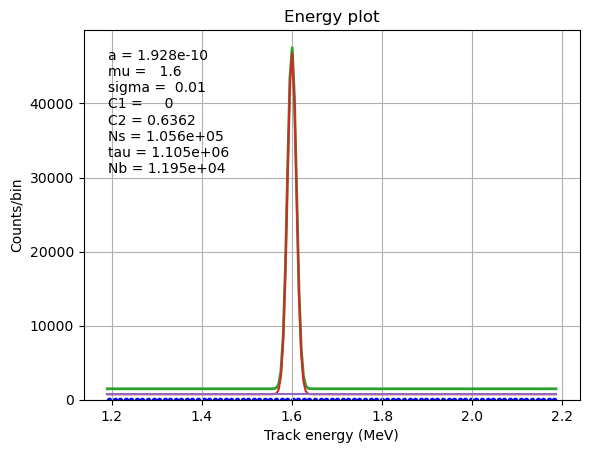

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.5 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


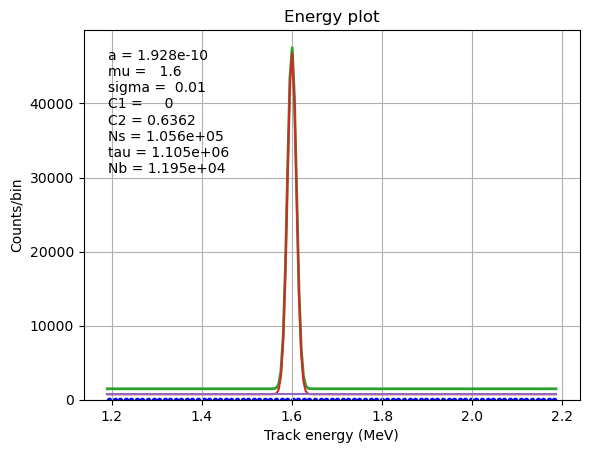

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.51 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


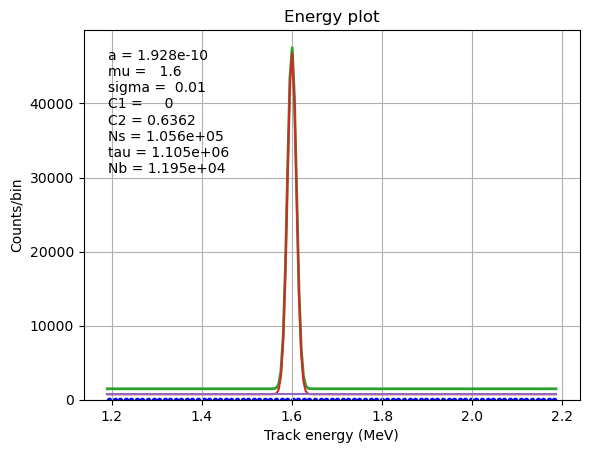

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.52 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


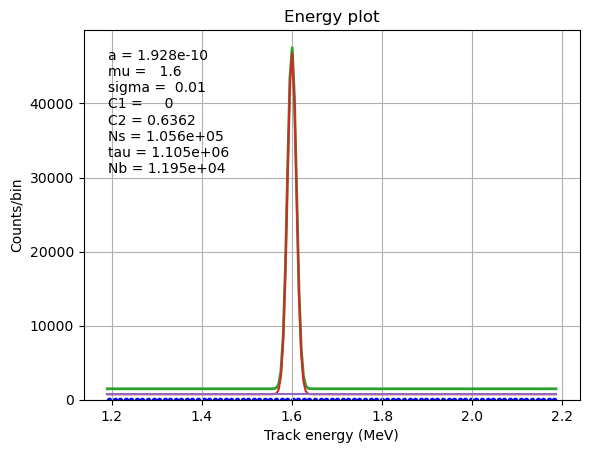

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.53 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


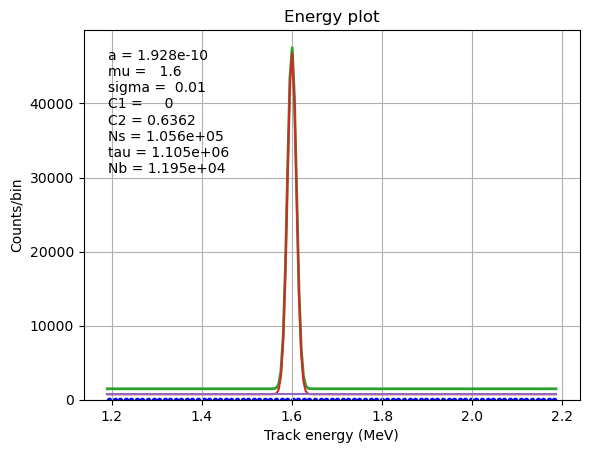

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.54 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


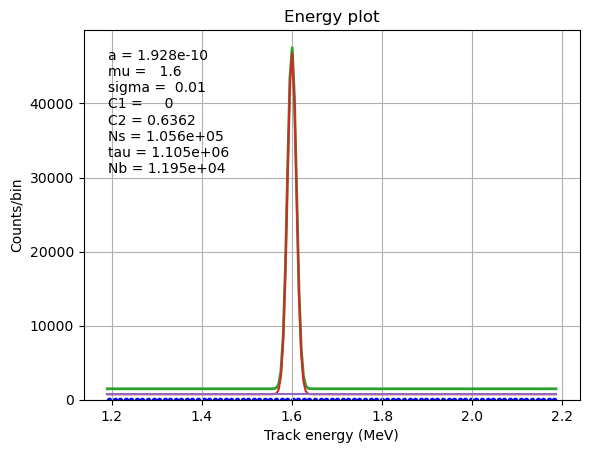

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.55 MeV
Mu fit completed, with values:
mu: 1.5999999999640746
sigma: 0.009999999997099855


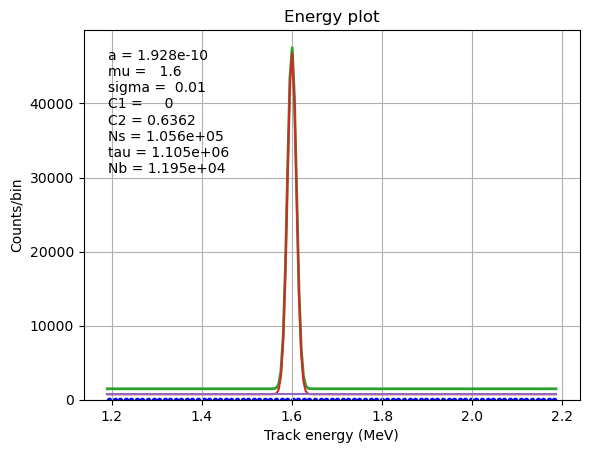

Signal events: 105637.03030619741
Background events: 11935.339269791048
Total Events by addition: 117572.36957598846
Total Events by row counting: 1


Blob cut: 0.56 MeV


ValueError: zero-size array to reduction operation minimum which has no identity

In [26]:
for i in range(len(cut_list)):
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    print("")
    print("")
    print("====================================")
    print("Blob cut: {} MeV".format(cut_list[i]))
    print("====================================")
    # fit gaussian for mu and sigma    
    #holder = gaussian_fit(blob_data)
    #mu = holder[0]
    #sigma = holder[1]

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']
    binning = 80
    g_popt, g_pcov = func.histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("Mu fit completed, with values:\nmu: {}\nsigma: {}".format(mu,sigma))
    holder_sb = sb_fit(blob_data, mu, sigma, C1, C2, plot = True)

    ns_l.append(holder_sb[0])
    nb_l.append(holder_sb[1])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)))
    
    # efficiency and background rej
    e_check = ns_l[i]/ns_l[0]
    b_check = nb_l[i]/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
    b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data, mu, sigma, g_popt, g_pcov, holder_sb

    print("====================================")

In [27]:
print(fom)
plot = True

[1.0, 1.0, 1.021359021480777, 1.0684727674550953, 1.1595971318970688, 1.2742640344812126, 1.4086655888410162, 1.544290152740556, 1.6657500001465264, 1.7465054625409226, 1.8911918533448335, 2.070902810718735, 2.0702213470285247, 2.1016550479898854, 2.2014381965234393, 2.2806064651372733, 2.347615469867967, 2.4102612837085897, 2.504213471369933, 2.544510316307207, 2.430749729704272, 2.332122135398897, 2.3365676468823704, 2.39470995877093, 2.4673369280212762, 2.6949056283447836, 2.879676443708741, 2.9878660695796815, 3.651146883089066, 3.0627367912242924, 2.7410161001804916, nan, nan, 2.4259853681342, 1.539658293328799, 2.308097304915118, 0.7264494601056762, 0.8559543526865795, 1.7295516308174061, 0.4252147949405481, 0.2927821963752288, 0.16893581436855917, 0.023760145229015817, 0.0641855582810981, 0.08891915197396845, 0.011902924946654325, 0.011902924946654325, 0.011902924946654325, nan, 14.00069568437802, 14.00069568437802, 14.00069568437802, 14.00069568437802, 14.00069568437802, 14.000

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   221466.6610722 Edm =       152867 NCalls =     11
VariableMetric: Iteration #   0 - FCN =   221466.6610722 Edm =       152867 NCalls =     11
VariableMetric: Iteration #   1 - FCN =  -45433.49578387 Edm =      3.24233 NCalls =     32
VariableMetric: Iteration #   2 - FCN =  -47387.59665699 Edm =      21.3433 NCalls =     47
VariableMetric: Iteration #   3 - FCN =  -47417.46503538 Edm =      1.57392 NCalls =     55
VariableMetric: Iteration #   4 - FCN =  -47421.37352002 Edm =     0.386177 NCalls =     63
VariableMetric: Iteration #   5 - FCN =  -47421.89157082 Edm =    0.0302811 NCalls =     71
VariableMetric: Iteration #   6 - FCN =  -47423.19952469 Edm =      1.11257 NCalls =     81
VariableMetric: Iteration #   7 - FCN =  -47787.71625605 Edm =      534.163 NCalls =     99
VariableMetric: Iteration #   8 - FCN =  -47788.87411038 Edm =     0.957382 NCalls =    107
VariableMetric: Iteration 

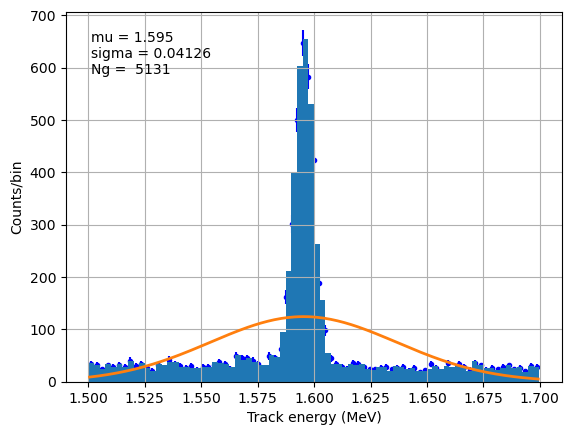

NameError: name 'pdf_sb' is not defined

In [18]:
'''
for i in range(len(cut_list)):
    try:
        del lh_sb, vals_sb, nm_sb, m_sb, m_g, lh_g,
    except:
        pass
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    blob_np = blob_data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1),  print_level = 2)
    
    # minimise it
    m_g.migrad()

    print("Finished fitting gaussian")
    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_g.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']

    # now do full fit
    try:
        del lh_sb, vals_sb, nm_sb, m_sb
    except:
        pass
    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [fit_params['Ng'], len(blob_np) - fit_params['Ng'], 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)

    # minimise that mfer
    m_sb.migrad()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    ns_l.append(fit_params['Ns'])
    nb_l.append(fit_params['Nb'])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(blob_data[0].index)))

    # efficiency and background rej
    e_check = fit_params['Ns']/ns_l[0]
    b_check = fit_params['Nb']/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns[i],ns[0],np.sqrt(ns[i]),np.sqrt(ns[0])))
    b_err.append(func.ratio_error(b[i],nb[i],nb[0],np.sqrt(nb[i]),np.sqrt(nb[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data
'''

In [28]:
print(fom)

[1.0, 1.0, 1.021359021480777, 1.0684727674550953, 1.1595971318970688, 1.2742640344812126, 1.4086655888410162, 1.544290152740556, 1.6657500001465264, 1.7465054625409226, 1.8911918533448335, 2.070902810718735, 2.0702213470285247, 2.1016550479898854, 2.2014381965234393, 2.2806064651372733, 2.347615469867967, 2.4102612837085897, 2.504213471369933, 2.544510316307207, 2.430749729704272, 2.332122135398897, 2.3365676468823704, 2.39470995877093, 2.4673369280212762, 2.6949056283447836, 2.879676443708741, 2.9878660695796815, 3.651146883089066, 3.0627367912242924, 2.7410161001804916, nan, nan, 2.4259853681342, 1.539658293328799, 2.308097304915118, 0.7264494601056762, 0.8559543526865795, 1.7295516308174061, 0.4252147949405481, 0.2927821963752288, 0.16893581436855917, 0.023760145229015817, 0.0641855582810981, 0.08891915197396845, 0.011902924946654325, 0.011902924946654325, 0.011902924946654325, nan, 14.00069568437802, 14.00069568437802, 14.00069568437802, 14.00069568437802, 14.00069568437802, 14.000

In [29]:
cut_list = np.linspace(0,0.35, 36)

No handles with labels found to put in legend.


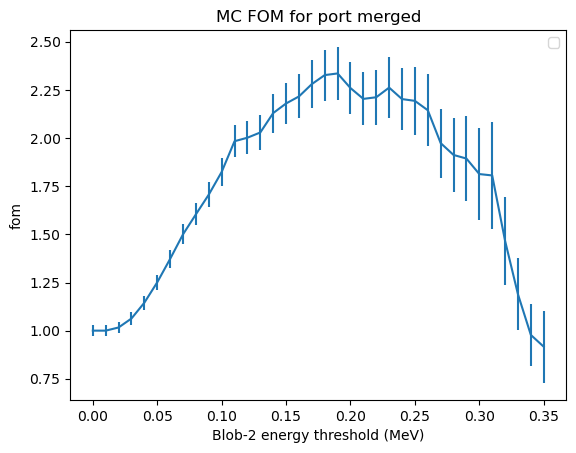

In [30]:
fom_MC = func.true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

ns = fom_MC[2]
nb = fom_MC[3]
fom_erro = np.nan_to_num(fom_MC[1])
fom_out = np.nan_to_num(fom_MC[0])

plt.errorbar(cut_list, fom_out, yerr = fom_erro)
plt.title("MC FOM for port merged")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.legend()

plt.ylabel("fom")
plt.show()

In [31]:
print(len(fom))

56


In [32]:
cut_list_fit = np.linspace(0,0.55, 56)

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/numpy/ma/core.py:3381: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


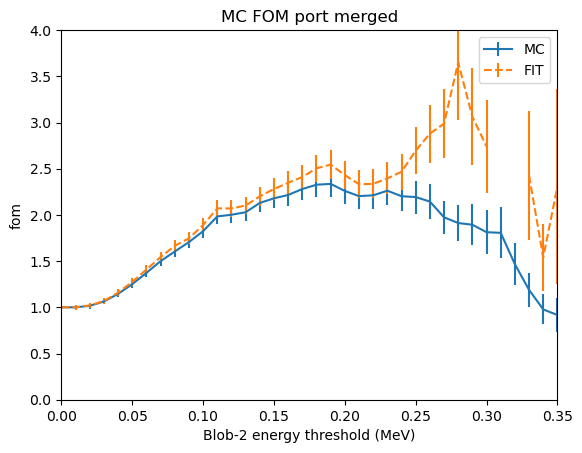

In [36]:
plt.errorbar(cut_list, fom_out, yerr = fom_erro, label = 'MC')
plt.errorbar(cut_list_fit, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
plt.legend()
plt.title("MC FOM port merged")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.xlim([0,0.35])
plt.ylim([0,4])
plt.ylabel("fom")
plt.show()

In [91]:
'''
e_s2 = np.append(e_s, e_s2)
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s2, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s2, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s2), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s2), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m2 = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

In [34]:
np.save('data/fom_fit_isaura_merged.npy', fom)
np.save('data/fom_fit_err_isaura_merged.npy', fom_err)
np.save('data/fom_MC_isaura_merged.npy', fom_out)
np.save('data/fom_MC_err_isaura_merged.npy', fom_erro)

In [92]:
'''
# minimise that mfer
m2.migrad()
heights, bins, _ = plt.hist(e_s2, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)
plt.show()
'''

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   0 - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   1 - FCN =  -103883.8363617 Edm =      6118.56 NCalls =    119
VariableMetric: Iteration #   2 - FCN =  -108560.6179698 Edm =       914.85 NCalls =    143
VariableMetric: Iteration #   3 - FCN =  -108715.0329486 Edm =      451.082 NCalls =    159
VariableMetric: Iteration #   4 - FCN =  -108822.0763603 Edm =      29.2179 NCalls =    173
VariableMetric: Iteration #   5 - FCN =  -108830.6308968 Edm =      14.9261 NCalls =    187
VariableMetric: Iteration #   6 - FCN =  -108842.8533993 Edm =      4.13233 NCalls =    201
VariableMetric: Iteration #   7 - FCN =  -108850.6622825 Edm =      1.94108 NCalls =    215
VariableMetric: Iteration #   8 - FCN =  -108871.5466668 Edm =      10.4149 NCalls =    233
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.089e+05                 │        Nfcn = 376 (376 total)        │
│ EDM = 2.87e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.49    │   0.28    │            │            │         │         │       │
│ 1 │ mu    │  1.5939   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.73e-3  │  0.31e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.361   │   0.023   │            │            │    0    │         │       │
│ 4 │ C2    │   0.297   │   0.020   │            │            │    0    │         │       │
│ 5 │ Ns    │  9.39e3   │  0.10e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [36]:
test = np.load('data/fom_fit.npy')
print(test)

[1.         1.         1.00783633 1.03175901 1.08084012 1.16535834
 1.25313252 1.37277737 1.49315832 1.617329   1.71711929 1.80310433
 1.91390578 2.05241509 2.18071868 2.32241737 2.43892065 2.51700152
 2.49711649 2.51333411 2.53407889 2.54255474 2.55964242 2.53972371
 2.5362615  2.52928113 2.52160151 2.48350147 2.52386446 2.51541374
 2.34044961 2.49881868 2.45386654 2.39762317 2.41270768 2.34797239
 2.14480602 2.1104387  2.0348056  1.65507467 1.46494797 1.51717247
 1.51303867 1.30528955 1.14064372 1.34130759 1.05922434 0.91590526
 0.7165015  0.53646691 0.3310788  0.3378764  0.21455947 0.14866301
 0.09503777 0.06944191 0.00874405 0.02292246        nan        nan
        nan]
